In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from spectral import SpectralNorm
import numpy as np
from torchsummary import summary
from tensorboardX import SummaryWriter
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
torch.cuda.is_available()

True

In [3]:
!which python

/opt/anaconda3/envs/fastai/bin/python


In [4]:
device

'cuda'

In [5]:
import os
import time
import torch
import datetime
import itertools

import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from tensorboardX import SummaryWriter

from sagan_models import Generator, Discriminator, Encoder
from utils import *

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
import tester
from sagan_models import Generator, Encoder, Discriminator
from data_loader import Data_Loader
from utils import denorm

In [7]:
batch_size = 64
G = Generator(batch_size, 64, 128, 64).to(device)
E = Encoder(batch_size, 64, 128, 64).to(device)
D = Discriminator(batch_size, 64, 128, 64).to(device)

In [8]:
ds = Data_Loader(True, 'mura', 'XR_HAND', '', '/home/phuc/datasets/', 64, 64)
dl = ds.loader()

Dataset lengh:  5543


In [9]:
model_save_path = 'models/sabigan_hand/166400'
G.load_state_dict(torch.load(model_save_path + '_G.pth'))
E.load_state_dict(torch.load(model_save_path + '_E.pth'))
D.load_state_dict(torch.load(model_save_path + '_D.pth'))
print('loaded trained models (step: {})..!'.format(model_save_path))

loaded trained models (step: models/sabigan_hand/166400)..!


In [10]:
data_iter = iter(dl)
with torch.no_grad(): 
    l1 = []
    l2 = []
    ld = []
    ld5 = []
    ld4 = []
    ld3 = []
    labels = []
    
    for i, data in enumerate(data_iter):
        val_images, val_labels = data
        val_images = tensor2var(val_images)
        labels.append(val_labels)

        # Run val images through models X -> E(X) -> G(E(X))
        z, ef1, ef2 = E(val_images)
        re_images, gf1, gf2 = G(z)

        dv, dv5, dv4, dv3, dvz, dva2, dva1 = D(val_images, z)
        dr, dr5, dr4, dr3, drz, dra2, dra1 = D(re_images, z)

        # Compute residual loss 
        l1.append((val_images - re_images).abs().view(re_images.size(0), -1).mean(dim=-1))
        l2.append((val_images - re_images).pow(2).sqrt().view(re_images.size(0), -1).mean(dim=-1))
        # Computer feature matching loss
        ld.append((dv - dr).view((dv.size(0), -1)).mean(dim=1))
        ld5.append((dv5 - dr5).view((dv5.size(0), -1)).mean(dim=1))
        ld4.append((dv4 - dr4).view((dv4.size(0), -1)).mean(dim=1))
        ld3.append((dv3 - dr3).view((dv3.size(0), -1)).mean(dim=1))

    l1 = np.stack(torch.cat(l1).cpu().data)
    l2 = np.stack(torch.cat(l2).cpu().data)
    ld = np.stack(torch.cat(ld).cpu().data)
    ld5 = np.stack(torch.cat(ld5).cpu().data)
    ld4 = np.stack(torch.cat(ld4).cpu().data)
    ld3 = np.stack(torch.cat(ld3).cpu().data)
    labels = np.stack(torch.cat(labels).cpu().data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


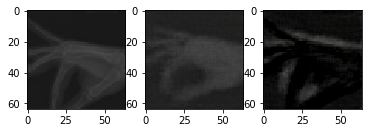

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


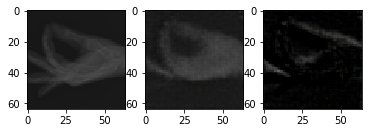

Press Enter to continue... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


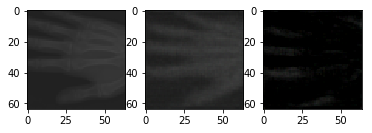

KeyboardInterrupt: 

In [12]:
for i in range(val_images.size(0)):
    plt.subplot(131)
    plt.imshow(denorm(val_images[i]).transpose(0,2))
    plt.subplot(132)
    plt.imshow(denorm(re_images[i]).transpose(0,2))
    plt.subplot(133)
    plt.imshow(((re_images[i]-val_images[i])).transpose(0,2))
    plt.show()
    input("Press Enter to continue...") 

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


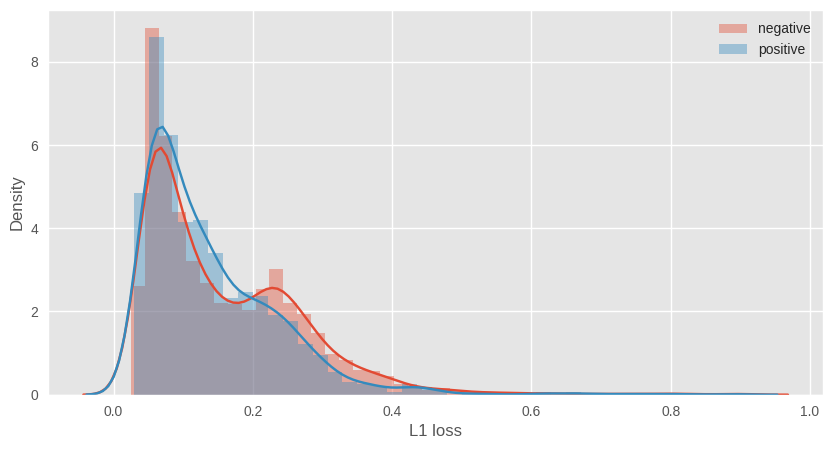

In [29]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.distplot(l1[labels==0].clip(max=0.9), hist=True, label='negative')
sns.distplot(l1[labels==1].clip(max=0.9), hist=True, label='positive')
plt.xlabel('L1 loss')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


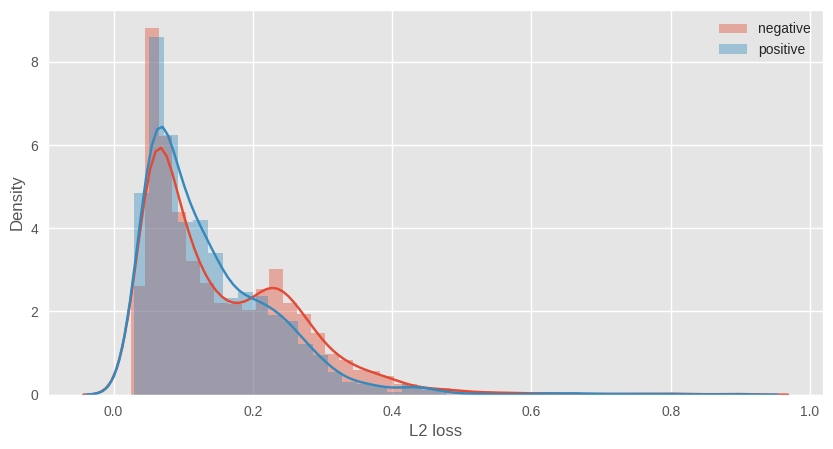

In [30]:
plt.figure(figsize=(10, 5))
sns.distplot(l2[labels==0].clip(max=0.9), hist=True, label='negative')
sns.distplot(l2[labels==1].clip(max=0.9), hist=True, label='positive')
plt.xlabel('L2 loss')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


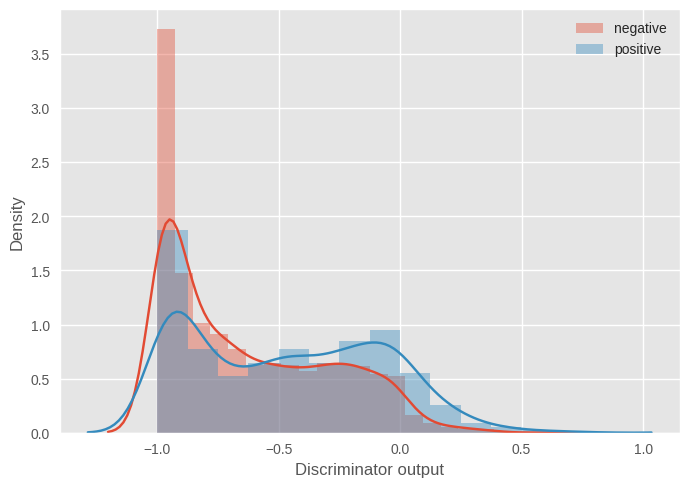

In [24]:
sns.distplot(ld[labels==0], hist=True, label='negative')
sns.distplot(ld[labels==1], hist=True, label='positive')
plt.xlabel('Discriminator output')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


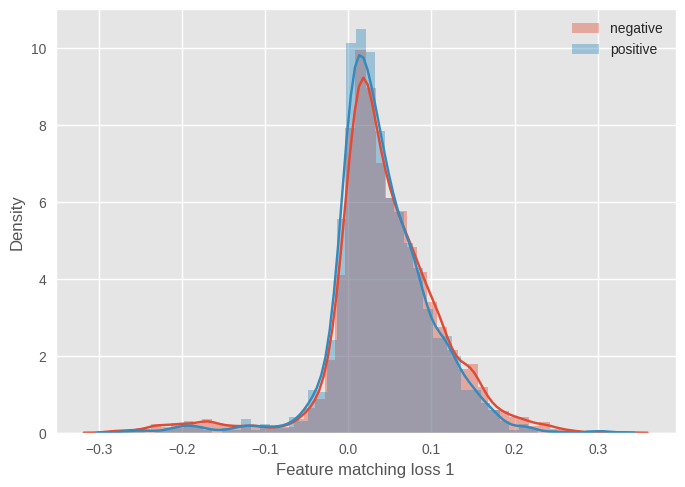

In [25]:
sns.distplot(ld5[labels==0], hist=True, label='negative')
sns.distplot(ld5[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching loss 1')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


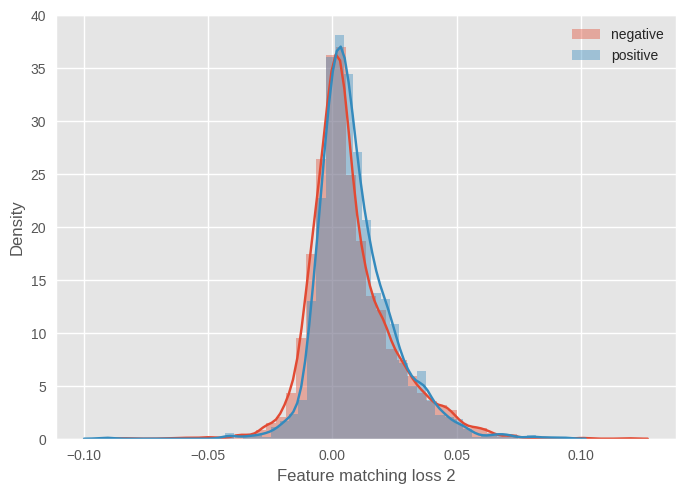

In [26]:
sns.distplot(ld4[labels==0], hist=True, label='negative')
sns.distplot(ld4[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching loss 2')
plt.ylabel('Density')
plt.legend()

/opt/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


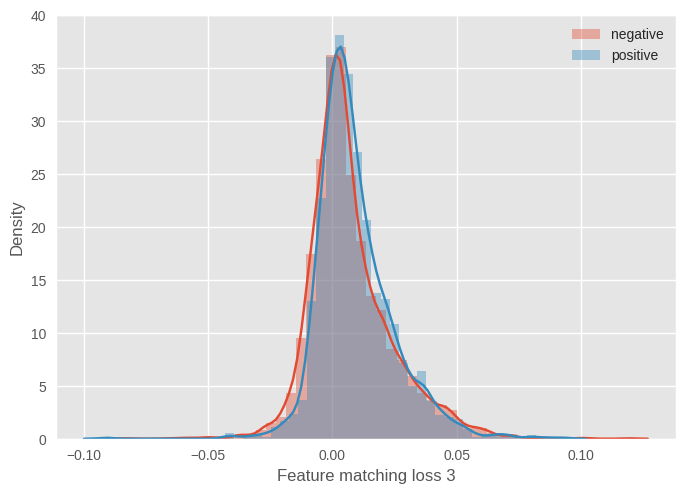

In [27]:
sns.distplot(ld4[labels==0], hist=True, label='negative')
sns.distplot(ld4[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching loss 3')
plt.ylabel('Density')
plt.legend()

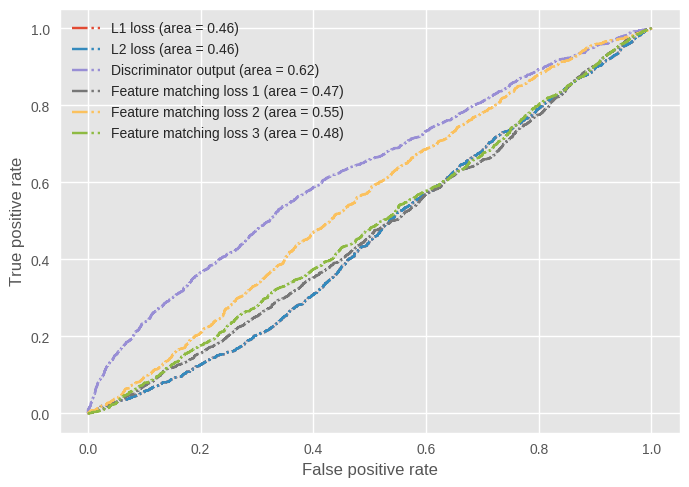

In [67]:
fpr, tpr, thresh = roc_curve(labels, l1)
auc = roc_auc_score(labels, l1)
plt.plot(fpr, tpr, '-.', label=f'L1 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l2)
auc = roc_auc_score(labels, l2)
plt.plot(fpr, tpr, '-.', label=f'L2 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld)
auc = roc_auc_score(labels, ld)
plt.plot(fpr, tpr, '-.', label=f'Discriminator output (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld5)
auc = roc_auc_score(labels, ld5)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 1 (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld4)
auc = roc_auc_score(labels, ld4)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 2 (area = {auc:.2f})')
                    
fpr, tpr, thresh = roc_curve(labels, ld3)
auc = roc_auc_score(labels, ld3)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 3 (area = {auc:.2f})')
                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()